# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Arguments" data-toc-modified-id="Arguments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Arguments</a></div><div class="lev1 toc-item"><a href="#MetaCyc-subset-of-QM9" data-toc-modified-id="MetaCyc-subset-of-QM9-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MetaCyc subset of QM9</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{QM9}-compounds-to-reactions" data-toc-modified-id="Delta-G^\circ_{QM9}-compounds-to-reactions-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>$\Delta G^\circ_{QM9}$ compounds to reactions</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{QM9}-vs-\Delta-G^\circ_{GCM}" data-toc-modified-id="Delta-G^\circ_{QM9}-vs-\Delta-G^\circ_{GCM}-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>$\Delta G^\circ_{QM9}$ vs $\Delta G^\circ_{GCM}$</a></div><div class="lev1 toc-item"><a href="#Define-model-and-optimizer" data-toc-modified-id="Define-model-and-optimizer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define model and optimizer</a></div><div class="lev1 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Statistics</a></div><div class="lev1 toc-item"><a href="#Create-model" data-toc-modified-id="Create-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create model</a></div><div class="lev1 toc-item"><a href="#get-the-best-checkpoint-if-available-without-training" data-toc-modified-id="get-the-best-checkpoint-if-available-without-training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>get the best checkpoint if available without training</a></div>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

import time
import argparse
import os
import numpy as np
import sys
sys.path.append(os.getcwd())
# Our Modules
import utils
from utils import datasets
from models.MPNN import MPNN
from models.MPNNv2 import MPNNv2
from models.MPNNv3 import MPNNv3
from utils.LogMetric import AverageMeter, Logger


# Arguments

In [2]:
parser = argparse.ArgumentParser(description='Neural message passing')

parser.add_argument('--dataset', default='qm9', help='QM9')
parser.add_argument('--edge-rep', default='raw_distance', choices=['raw_distance','chem_graph','distance_bin'] )
parser.add_argument('--datasetPath', default='./mpnn-data/qm9/dsgdb9nsd/', help='dataset path')
parser.add_argument('--logPath', default='./log/qm9/mpnn/', help='log path')
parser.add_argument('--plotLr', default=False, help='allow plotting the data')
parser.add_argument('--plotPath', default='./plot/qm9/mpnn/', help='plot path')
parser.add_argument('--resume', default='./checkpoint/qm9/mpnn/',
                    help='path to latest checkpoint')
# Optimization Options
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='Input batch size for training (default: 20)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Enables CUDA training')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='Number of epochs to train (default: 50)')
parser.add_argument('--lr', type=lambda x: restricted_float(x, [1e-5, 1e-2]), default=1e-3, metavar='LR',
                    help='Initial learning rate [1e-5, 5e-4] (default: 1e-4)')
parser.add_argument('--lr-decay', type=lambda x: restricted_float(x, [.01, 1]), default=0.6, metavar='LR-DECAY',
                    help='Learning rate decay factor [.01, 1] (default: 0.6)')
parser.add_argument('--schedule', type=list, default=[0.1, 0.9], metavar='S',
                    help='Percentage of epochs to start the learning rate decay [0, 1] (default: [0.1, 0.9])')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
# i/o
parser.add_argument('--log-interval', type=int, default=20, metavar='N',
                    help='How many batches to wait before logging training status')
# Accelerating
parser.add_argument('--prefetch', type=int, default=2, help='Pre-fetching threads.')

# Model modification
parser.add_argument('--model', type=str,help='MPNN model name [MPNN, MPNNv2, MPNNv3]',
                        default='MPNN')


args = parser.parse_args(['--model','MPNNv2', '--edge-rep','chem_graph', '--no-cuda'])
print(args)


Namespace(batch_size=100, dataset='qm9', datasetPath='./mpnn-data/qm9/dsgdb9nsd/', edge_rep='chem_graph', epochs=50, logPath='./log/qm9/mpnn/', log_interval=20, lr=0.001, lr_decay=0.6, model='MPNNv2', momentum=0.9, no_cuda=True, plotLr=False, plotPath='./plot/qm9/mpnn/', prefetch=2, resume='./checkpoint/qm9/mpnn/', schedule=[0.1, 0.9])


In [3]:
def restricted_float(x, inter):
    x = float(x)
    if x < inter[0] or x > inter[1]:
        raise argparse.ArgumentTypeError("%r not in range [1e-5, 1e-4]"%(x,))
    return x


In [4]:

best_er1 = 0

    # Check if CUDA is enabled
args.cuda = not args.no_cuda and torch.cuda.is_available()

    # Load data
root = args.datasetPath
root

'./mpnn-data/qm9/dsgdb9nsd/'

# MetaCyc subset of QM9

In [105]:
print('Prepare files')
import pandas as pd
qm9_metacyc = pd.read_table('Dataset/QM9_metacyc.tab')
qm9_metacyc

Prepare files


,FrameId,Name,Kegg,InChI,Smiles,Gibbs-0,cpd,nC
0,BUTYRAMIDE,butyramide,NIL,"InChI=1S/C4H9NO/c1-2-3-4(5)6/h2-3H2,1H3,(H2,5,6)",CCCC(N)=O,51.370094,./dsgdb9nsd_000262.xyz,4
1,CPD-282,cyclohex-2-enone,C02395,"InChI=1S/C6H8O/c7-6-4-2-1-3-5-6/h2,4H,1,3,5H2",C1(CCC(C=C1)=O),76.978966,./dsgdb9nsd_002060.xyz,6
2,CPD-7031,3-methylbutanal,C07329,"InChI=1S/C5H10O/c1-5(2)3-4-6/h4-5H,3H2,1-2H3",CC(C)C[CH]=O,71.711205,./dsgdb9nsd_000255.xyz,5
3,CPD-9383,glycine methyl ester,NIL,"InChI=1S/C3H7NO2/c1-6-3(5)2-4/h2,4H2,1H3",C([NH2])C(=O)OC,-3.392161,./dsgdb9nsd_000365.xyz,3
4,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004243.xyz,4
5,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004318.xyz,4
6,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004371.xyz,4
7,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004403.xyz,4
8,URACIL,uracil,C00106,"InChI=1S/C4H4N2O2/c7-3-1-2-5-4(8)6-3/h1-2H,(H2...",C1(=CC(NC(=O)N1)=O),-28.995518,./dsgdb9nsd_004258.xyz,4
9,URACIL,uracil,C00106,"InChI=1S/C4H4N2O2/c7-3-1-2-5-4(8)6-3/h1-2H,(H2...",C1(=CC(NC(=O)N1)=O),-28.995518,./dsgdb9nsd_004294.xyz,4


In [24]:
files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))
                                        and './' + os.path.basename(f) in 
                                             set(qm9_metacyc['cpd'].values)]

idx = np.random.permutation(len(files))
idx = idx.tolist()
idx

[340,
 142,
 310,
 11,
 174,
 63,
 252,
 370,
 17,
 391,
 59,
 69,
 15,
 232,
 56,
 198,
 95,
 196,
 367,
 104,
 208,
 342,
 316,
 124,
 304,
 0,
 20,
 291,
 67,
 7,
 119,
 172,
 33,
 381,
 350,
 205,
 158,
 226,
 220,
 360,
 9,
 298,
 147,
 81,
 68,
 96,
 45,
 89,
 31,
 279,
 128,
 106,
 61,
 170,
 274,
 14,
 169,
 199,
 87,
 163,
 202,
 314,
 137,
 146,
 62,
 18,
 309,
 101,
 109,
 393,
 177,
 107,
 390,
 22,
 143,
 293,
 207,
 259,
 195,
 37,
 80,
 336,
 30,
 349,
 54,
 267,
 102,
 288,
 345,
 296,
 233,
 77,
 1,
 230,
 357,
 209,
 218,
 228,
 396,
 215,
 4,
 311,
 187,
 141,
 364,
 368,
 46,
 394,
 273,
 71,
 85,
 74,
 83,
 186,
 19,
 192,
 323,
 248,
 99,
 34,
 75,
 372,
 278,
 227,
 376,
 375,
 179,
 212,
 366,
 129,
 290,
 250,
 332,
 321,
 175,
 333,
 57,
 373,
 326,
 39,
 82,
 312,
 219,
 2,
 204,
 355,
 266,
 122,
 181,
 282,
 389,
 264,
 108,
 182,
 193,
 160,
 132,
 287,
 184,
 295,
 90,
 258,
 153,
 260,
 36,
 374,
 42,
 300,
 338,
 380,
 157,
 43,
 359,
 327,
 185,
 111,


## $\Delta G^\circ_{QM9}$ compounds to reactions

In [22]:
qm9_metacyc_dict = qm9_metacyc.set_index('cpd').to_dict()['FrameId']
qm9_metacyc_dict

{'./dsgdb9nsd_000001.xyz': 'CH4',
 './dsgdb9nsd_000002.xyz': 'AMMONIA',
 './dsgdb9nsd_000003.xyz': 'WATER',
 './dsgdb9nsd_000004.xyz': 'ACETYLENE',
 './dsgdb9nsd_000005.xyz': 'HCN',
 './dsgdb9nsd_000006.xyz': 'FORMALDEHYDE',
 './dsgdb9nsd_000007.xyz': 'CPD-9312',
 './dsgdb9nsd_000008.xyz': 'METOH',
 './dsgdb9nsd_000009.xyz': 'CPD-19558',
 './dsgdb9nsd_000011.xyz': 'ACETALD',
 './dsgdb9nsd_000012.xyz': 'FORMAMIDE',
 './dsgdb9nsd_000013.xyz': 'CPD-18984',
 './dsgdb9nsd_000014.xyz': 'ETOH',
 './dsgdb9nsd_000017.xyz': 'CPD-19003',
 './dsgdb9nsd_000018.xyz': 'ACETONE',
 './dsgdb9nsd_000019.xyz': 'ACETAMIDE',
 './dsgdb9nsd_000020.xyz': 'UREA',
 './dsgdb9nsd_000021.xyz': 'CPD-19056',
 './dsgdb9nsd_000022.xyz': 'ISO-PROPANOL',
 './dsgdb9nsd_000026.xyz': 'CPD-15163',
 './dsgdb9nsd_000028.xyz': 'CPD-8887',
 './dsgdb9nsd_000031.xyz': 'CPD-8860',
 './dsgdb9nsd_000035.xyz': 'CPD-665',
 './dsgdb9nsd_000037.xyz': 'CPD-18959',
 './dsgdb9nsd_000038.xyz': 'GLYCOLALDEHYDE',
 './dsgdb9nsd_000039.xyz': 'CP

In [23]:
metacyc_files = [(qm9_metacyc_dict['./' + os.path.basename(f)],f) for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))
                                        and './' + os.path.basename(f) in qm9_metacyc_dict]
dict(metacyc_files)

{'2-5-DIHYDROXYPYRIDINE': 'dsgdb9nsd_004614.xyz',
 '2-AMINOPHENOL': 'dsgdb9nsd_004979.xyz',
 '2-BUTYNE-14-DIOL': 'dsgdb9nsd_000519.xyz',
 '2-DEHYDROPANTOYL-LACTONE': 'dsgdb9nsd_064066.xyz',
 '2-DEOXYRIBOSE': 'dsgdb9nsd_100842.xyz',
 '2-HYDROXY-2-METHYLPROPANENITRILE': 'dsgdb9nsd_000223.xyz',
 '2-HYDROXYPYRIDINE': 'dsgdb9nsd_000954.xyz',
 '2-METHOXYETHANOL': 'dsgdb9nsd_000137.xyz',
 '23-PENTANEDIONE': 'dsgdb9nsd_001644.xyz',
 '3-CYANOPYRIDINE': 'dsgdb9nsd_005349.xyz',
 '3-METHYLBENZYL-ALCOHOL': 'dsgdb9nsd_032071.xyz',
 '3-OH-BENZALDEHYDE': 'dsgdb9nsd_027964.xyz',
 '3-OH-BENZYL-ALCOHOL': 'dsgdb9nsd_032171.xyz',
 '4-AMINO-BUTYRATE': 'dsgdb9nsd_001290.xyz',
 '4-HYDROXY-2-BUTYNAL': 'dsgdb9nsd_000516.xyz',
 '4-HYDROXY-BENZYL-ALCOHOL': 'dsgdb9nsd_031871.xyz',
 '4-HYDROXY-L-PROLINE': 'dsgdb9nsd_093943.xyz',
 '4-METHYLBENZYL-ALCOHOL': 'dsgdb9nsd_031794.xyz',
 '4-METHYLCATECHOL': 'dsgdb9nsd_028440.xyz',
 '4-METHYLPENTANAL': 'dsgdb9nsd_001247.xyz',
 '4-METHYLRESORCINOL': 'dsgdb9nsd_028444.xyz',
 

In [137]:
qm9_metacyc_graphs = utils.Qm9(root,
                               sorted(qm9_metacyc_dict.keys()),
                               edge_transform=datasets.qm9_edges, 
                               e_representation=args.edge_rep )
qm9_metacyc_vals = utils.datasets.get_values(qm9_metacyc_graphs, 
                                             0, 
                                             len(qm9_metacyc_graphs), 
                                             ['target_mean','target_std'])
qm9_metacyc_param = np.array([file_res['params'] for file_res in qm9_metacyc_vals])
qm9_metacyc_dG = pd.Series(qm9_metacyc_param[:,-2], 
                           index=[qm9_metacyc_dict[f] 
                                  for f in sorted(qm9_metacyc_dict)])
qm9_metacyc_dG.to_csv('QM9_DFT_deltaG0f.tab',index=True, sep='\t')
qm9_metacyc_dG

CH4                      -40.498597
AMMONIA                  -56.544961
WATER                    -76.422349
ACETYLENE                -77.327429
HCN                      -93.431246
FORMALDEHYDE            -114.505268
CPD-9312                 -79.787269
METOH                   -115.701876
CPD-19558               -116.633775
ACETALD                 -153.812518
FORMAMIDE               -169.885594
CPD-18984               -119.078157
ETOH                    -154.998148
CPD-19003               -153.766642
ACETONE                 -193.116476
ACETAMIDE               -209.187468
UREA                    -225.247724
CPD-19056               -158.370016
ISO-PROPANOL            -194.294663
CPD-15163               -190.650543
CPD-8887                -227.825074
CPD-8860                -172.032826
CPD-665                 -193.102798
CPD-18959               -229.041086
GLYCOLALDEHYDE          -229.019918
CPD-18985               -158.368940
PROPANOL                -194.288930
GLYCOL                  -230

In [138]:
qm9_metacyc_dG_min = qm9_metacyc_dG.reset_index().groupby('index').min().dropna()
qm9_metacyc_dG_min

,0
index,
2-5-DIHYDROXYPYRIDINE,-398.697434
2-AMINOPHENOL,-362.761949
2-BUTYNE-14-DIOL,-306.345991
2-DEHYDROPANTOYL-LACTONE,-459.053741
2-DEOXYRIBOSE,-497.331001
2-HYDROXY-2-METHYLPROPANENITRILE,-286.536500
2-HYDROXYPYRIDINE,-323.477888
2-METHOXYETHANOL,-269.494828
23-PENTANEDIONE,-345.729675


In [135]:
stoich_matrix = pd.read_table('Dataset/QM9.S',index_col=['Rxn','Metabolite'])['Stoichiometry']
rxns, metabs = stoich_matrix.index.levels
stoich_dict = stoich_matrix.to_dict()
S = pd.DataFrame(0,index=metabs, columns=rxns)
for rxn,metab in stoich_dict:   
    S.loc[metab,rxn] = stoich_dict[rxn, metab]
#S.loc['3-HYDROXY-4H-PYRID-4-ONE','CREATINASE-RXN'] = 1
S

Rxn,25-DIOXOPIPERAZINE-HYDROLASE-RXN,ACETONE-CYANHYDRIN-LYASE-RXN,CREATINASE-RXN,CREATININASE-RXN,CYANIDE-HYDRATASE-RXN,GLYCEROL-DEHYDRATASE-RXN,GUANIDINOACETASE-RXN,R141-RXN,R313-RXN,R63-RXN,RXN-12256,RXN-12261,RXN-12765,RXN-13561,RXN-14725,RXN-14726,RXN-17589,RXN-17609,RXN-9702
Metabolite,,,,,,,,,,,,,,,,,,,
2-HYDROXY-2-METHYLPROPANENITRILE,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3-CYANOPYRIDINE,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ACETALD,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
ACETONE,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ACETYLENE,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0
BENZALDEHYDE,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0
BENZYL-ALCOHOL,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0
BUTYRAMIDE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0
CPD-10303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1


In [140]:
deltaG = S.T.dot(qm9_metacyc_dG_min[0][metabs]).to_frame('$\Delta G^\circ_{QM9}$')
deltaG

,$\Delta G^\circ_{QM9}$
Rxn,
25-DIOXOPIPERAZINE-HYDROLASE-RXN,0.022328
ACETONE-CYANHYDRIN-LYASE-RXN,-0.011222
CREATINASE-RXN,-0.025354
CREATININASE-RXN,0.010346
CYANIDE-HYDRATASE-RXN,0.031999
GLYCEROL-DEHYDRATASE-RXN,-0.014831
GUANIDINOACETASE-RXN,-0.024487
R141-RXN,-0.062740
R313-RXN,0.023191


## $\Delta G^\circ_{QM9}$ vs $\Delta G^\circ_{GCM}$

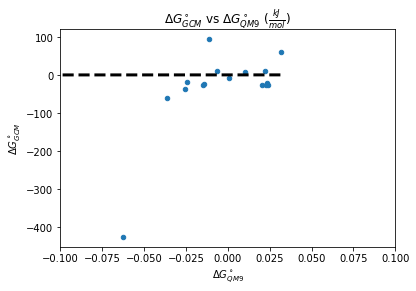

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')
deltaG['$\Delta G^\circ_{GCM}$'] = friendly_rxns.loc[rxns,'dG']*4.184
deltaG.plot(y='$\Delta G^\circ_{GCM}$',x='$\Delta G^\circ_{QM9}$',kind='scatter',title=r'$\Delta G^\circ_{GCM}$ vs $\Delta G^\circ_{QM9}$ ($\frac{kJ}{mol}$)',xlim=[-0.1,0.1])

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{GCM}$'].min(), 
                                deltaG['$\Delta G^\circ_{QM9}$'].min()),
                            min(deltaG['$\Delta G^\circ_{GCM}$'].max(), 
                                deltaG['$\Delta G^\circ_{QM9}$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/GCM_vs_QM9.png')

In [145]:
deltaG


,$\Delta G^\circ_{QM9}$,$\Delta G^\circ_{GCM}$
Rxn,,
25-DIOXOPIPERAZINE-HYDROLASE-RXN,0.022328,10.196393
ACETONE-CYANHYDRIN-LYASE-RXN,-0.011222,94.642093
CREATINASE-RXN,-0.025354,-37.710394
CREATININASE-RXN,0.010346,6.891045
CYANIDE-HYDRATASE-RXN,0.031999,61.015272
GLYCEROL-DEHYDRATASE-RXN,-0.014831,-26.974242
GUANIDINOACETASE-RXN,-0.024487,-18.589547
R141-RXN,-0.062740,-425.901954
R313-RXN,0.023191,-20.823741


In [ ]:
valid_ids = [files[i] for i in idx[0:100]]
test_ids = [files[i] for i in idx[100:200]]
train_ids = [files[i] for i in idx[200:]]

data_train = utils.Qm9(root, train_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_valid = utils.Qm9(root, valid_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_test = utils.Qm9(root, test_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)

# Define model and optimizer


In [7]:
print('Define model')
# Select one graph
g_tuple, l = data_train[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(data_valid, 0, len(data_valid), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

Define model


array([[  3.84000000e+00,   5.02400000e+01,  -2.42900000e-01, ...,
         -3.07571489e+02,  -3.07612431e+02,   2.52790000e+01],
       [  3.61930000e+00,   3.91300000e+01,  -2.25300000e-01, ...,
         -2.26156144e+02,  -2.26187104e+02,   1.33710000e+01],
       [  1.77170000e+00,   7.52600000e+01,  -2.52700000e-01, ...,
         -4.16893279e+02,  -4.16933921e+02,   2.81210000e+01],
       ..., 
       [  1.76750000e+00,   2.40400000e+01,  -2.68200000e-01, ...,
         -1.53738466e+02,  -1.53766642e+02,   9.17600000e+00],
       [  1.32230000e+00,   5.15000000e+01,  -2.52500000e-01, ...,
         -3.81625036e+02,  -3.81667220e+02,   2.62090000e+01],
       [  3.24170000e+00,   7.57400000e+01,  -2.22100000e-01, ...,
         -4.34146769e+02,  -4.34187834e+02,   3.08010000e+01]])

# Statistics

In [8]:
print('\tStatistics')
stat_dict = datasets.get_graph_stats(data_valid, ['target_mean', 'target_std'], multiprocess_p=False)
stat_dict

	Statistics


{'target_mean': array([  2.69689900e+00,   6.26179000e+01,  -2.40788000e-01,
         -1.22300000e-03,   2.39561000e-01,   9.14352607e+02,
          1.17970900e-01,  -3.52318540e+02,  -3.52311440e+02,
         -3.52310496e+02,  -3.52349674e+02,   2.59112000e+01]),
 'target_std': array([  1.90566044e+00,   1.67299833e+01,   2.74417648e-02,
          4.65505786e-02,   5.93242175e-02,   4.01016306e+02,
          3.57222303e-02,   9.62331120e+01,   9.62319063e+01,
          9.62319063e+01,   9.62355670e+01,   6.76316899e+00])}

In [9]:
data_train.set_target_transform(lambda x: datasets.normalize_data(x,stat_dict['target_mean'],
                                                                            stat_dict['target_std']))
data_valid.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict['target_mean'],
                                                                            stat_dict['target_std']))
data_test.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict['target_mean'],
                                                                           stat_dict['target_std']))

In [11]:
    train_loader = torch.utils.data.DataLoader(data_train,
                                               batch_size=args.batch_size, shuffle=True,
                                               collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(data_valid,
                                               batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(data_test,
                                              batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                              num_workers=args.prefetch, pin_memory=True)


# Create model

In [13]:
    in_n = [len(h_t[0]), len(list(e.values())[0])]
    hidden_state_size = 73
    message_size = 73
    n_layers = 3
    l_target = len(l)
    type ='regression'
    if args.model == 'MPNNv2':
        model = MPNNv2(in_n, [5, 15, 15], [10, 20, 20], l_target, type=type)
    elif args.model == 'MPNNv3':
        model = MPNNv3([1, 2, 3, 4], in_n, [5, 15, 15], 30, l_target, type=type)
    else:
        model = MPNN(in_n, hidden_state_size, message_size, n_layers, l_target, type=type)
    del in_n, hidden_state_size, message_size, n_layers, l_target, type

    print('Optimizer')
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    criterion = nn.MSELoss()

    evaluation = lambda output, target: torch.mean(torch.abs(output - target) / torch.abs(target))

    print('Logger')
    logger = Logger(args.logPath)

    lr_step = (args.lr-args.lr*args.lr_decay)/(args.epochs*args.schedule[1] - args.epochs*args.schedule[0])


Optimizer
Logger


# get the best checkpoint if available without training

In [14]:
if args.resume:
        checkpoint_dir = args.resume
        best_model_file = os.path.join(checkpoint_dir, 'model_best.pth')
        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        if os.path.isfile(best_model_file):
            print("=> loading best model '{}'".format(best_model_file))
            checkpoint = torch.load(best_model_file)
            args.start_epoch = checkpoint['epoch']
            best_acc1 = checkpoint['best_er1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded best model '{}' (epoch {})".format(best_model_file, checkpoint['epoch']))
        else:
            print("=> no best model found at '{}'".format(best_model_file))


=> loading best model './checkpoint/qm9/mpnn/model_best.pth'


AssertionError: Torch not compiled with CUDA enabled